In [2]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
from sklearn.svm import SVC
import wordcloud
import string
string.punctuation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.metrics import classification_report, confusion_matrix

# Overview

Spam messages are unimportant messages like advertisements for goods and services or business opportunities delivered to a big group of people without their permission. The project aims at classifying these messages as ham or spam for optimizing user effort. 

# Data Loading

In [3]:
sms=pd.read_csv('spam.csv')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='v1', ylabel='count'>

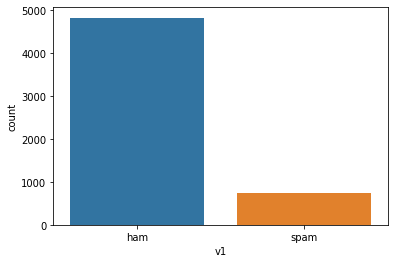

In [4]:
sns.countplot(sms['v1'])

The dataset contains 13.4% spam and 86.6% ham.

In [5]:
# Percentage of data points with ham label 
print(sms[sms['v1']=='ham'].shape[0]*100/sms.shape[0])

86.59368269921033


# EDA

In [6]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
sms.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [8]:
sms.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [9]:
sms=sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms.isnull().sum()

v1    0
v2    0
dtype: int64

In [10]:
sms=sms.rename({'v1':'label','v2':'text'},axis=1)
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Distribution based on length of words

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

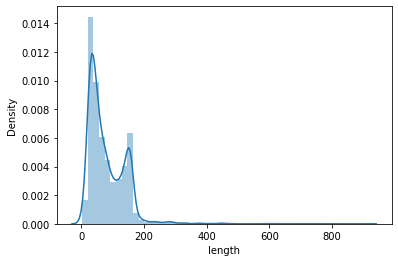

In [11]:
sms['length']=sms['text'].apply(lambda x: len(x))
sns.distplot(sms['length'], kde=True)

<AxesSubplot:xlabel='label', ylabel='length'>

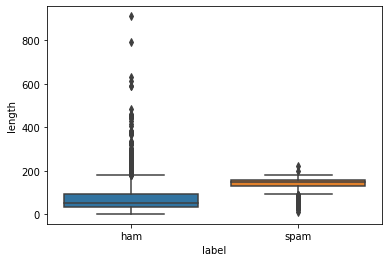

In [12]:
sns.boxplot(y='length', x='label', data=sms)

In [13]:
dt=sms.groupby('label').mean()
#sns.barplot(y='length', x='label', data=dt)
dt

,length
label,
ham,71.021347
spam,138.429719


In [14]:
sms.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.021347  58.014768   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.429719  29.049857  13.0  132.0  149.0  157.0  223.0

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

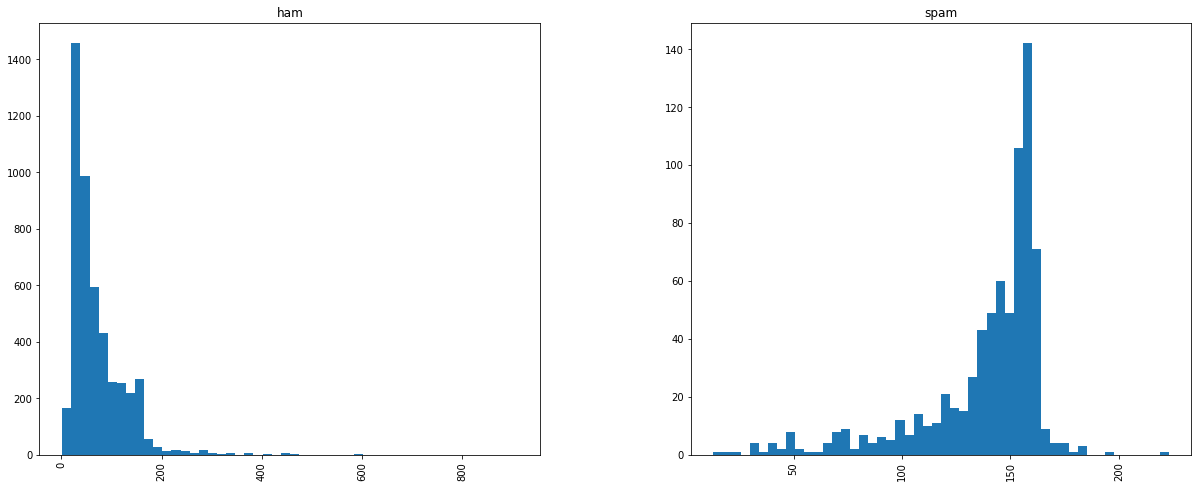

In [15]:
sms.hist(column='length', by='label', bins=50,figsize=(20,8))

In [16]:
ham=sms[sms['label']=='ham'].copy()
spam=sms[sms['label']=='spam'].copy()

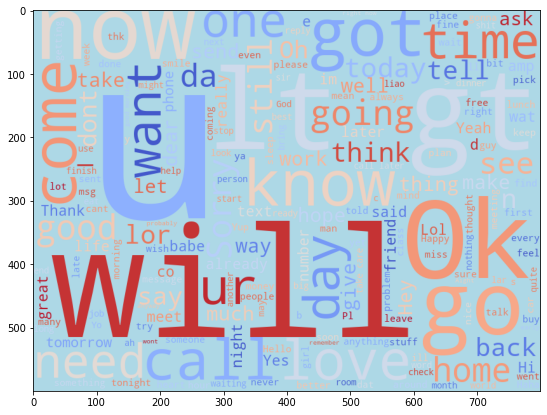

In [17]:
def show_wordcloud(df):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    diag = wordcloud.WordCloud(stopwords=stopwords,background_color='lightblue',
                    colormap='coolwarm', width=800, height=600).generate(text)
    
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(diag)  
    plt.show()

show_wordcloud(ham)

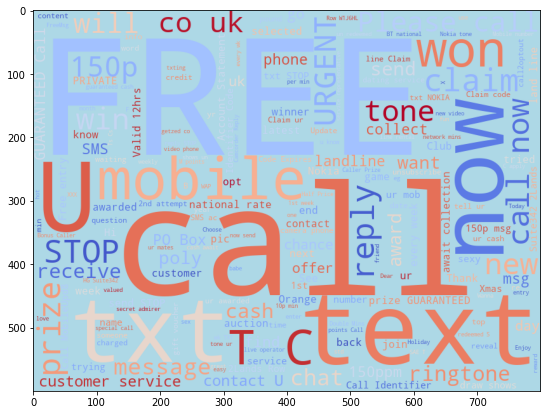

In [18]:
show_wordcloud(spam)

In [19]:
ham.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
6,ham,Even my brother is not like to speak with me. ...,77


In [20]:
def word_count_plot(x):
    a = [i for i in x if i not in string.punctuation]
    a = "".join(a).split()
    b = [word.lower() for word in a if word.lower() not in stopwords.words("english")]  
    return b

In [21]:
ham['text'] = ham['text'].apply(word_count_plot)
words_ham = ham['text'].tolist()
spam['text'] = spam['text'].apply(word_count_plot)
words_spam = spam['text'].tolist()

In [22]:
ham.head()

,label,text,length
0,ham,"[go, jurong, point, crazy, available, bugis, n...",111
1,ham,"[ok, lar, joking, wif, u, oni]",29
3,ham,"[u, dun, say, early, hor, u, c, already, say]",49
4,ham,"[nah, dont, think, goes, usf, lives, around, t...",61
6,ham,"[even, brother, like, speak, treat, like, aids...",77


In [23]:
ham_words = []
for i in words_ham:
    for item in i:
        ham_words.append(item)
spam_words = []
for i in words_spam:
    for item in i:
        spam_words.append(item)

In [24]:
from collections import Counter
ham_count  = Counter(ham_words)
df_ham  = pd.DataFrame(ham_count.most_common(10),  columns=['word', 'count'])
spam_count = Counter(spam_words)
df_spam = pd.DataFrame(spam_count.most_common(10), columns=['word', 'count'])

Top 10 ham words

<AxesSubplot:xlabel='word', ylabel='count'>

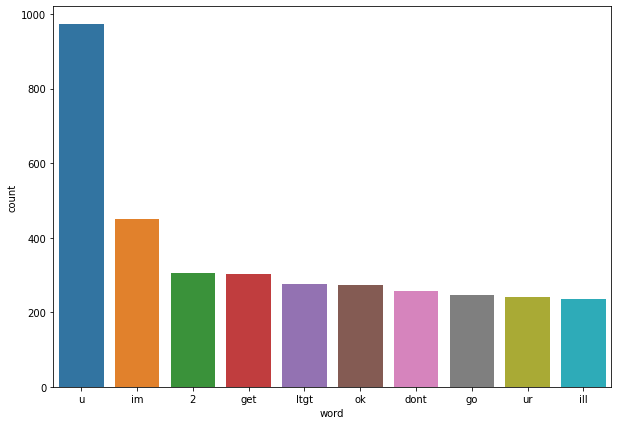

In [25]:
plt.figure(figsize=(10,7))
sns.barplot(x='word', y='count', data=df_ham)

Top 10 spam words

<AxesSubplot:xlabel='word', ylabel='count'>

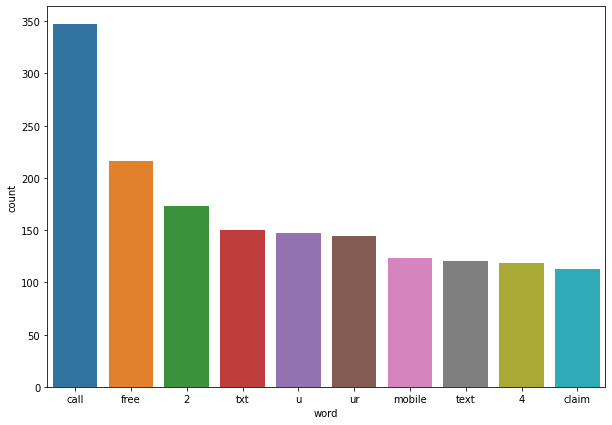

In [26]:
plt.figure(figsize=(10,7))
sns.barplot(x='word', y='count', data=df_spam)

# Data Preprocessing

Removing stopwords like 'where', 'why', 'how', 'all', 'any', 'both', 'each' and punctuation symbols is essential before text based predictions. These symbols have an impact on the prediction accuracy if not removed.

Stemming is the process of producing morphological variants of a root/base word. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”. Porter stemmer helps us stem text data used.

In [27]:
ps=PorterStemmer()
def preprocess(x):
    x = x.lower()
    x = re.sub(r'[^0-9a-zA-Z]', ' ', x)
    x = re.sub(r'\s+', ' ', x)
    l = [item for item in x if item not in string.punctuation]
    processed=[ps.stem(i) for i in l if i not in stopwords.words('english')]
    return processed


In [28]:
X=sms['text']
y=sms['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Pipeline 

Bag of words (BOW) / Bag of n-grams 

By using the bag-of-words technique, we convert a text into its equivalent vector of numbers. It involves 3 sub processes:
1. Tokenization - tokenizing strings and giving an integer id for each possible token by using white-spaces and punctuation as token separators.
2. Vectorization - counting the occurrences of tokens in each document.
3. TF-IDF - normalizing and weighting with diminishing importance tokens that occur in the majority of documents.

In [29]:
def model(model_name,X_train,y_train,X_test,y_test):
    pipeline=Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    return score
    


# MultinomialNB 

In [30]:
mnb=model(MultinomialNB(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1464
        spam       0.95      0.76      0.84       208

    accuracy                           0.97      1672
   macro avg       0.96      0.88      0.91      1672
weighted avg       0.96      0.97      0.96      1672

[[1456    8]
 [  50  158]]
Accuracy: 96.5311004784689
Training Score: 96.25641025641025


# RF

In [31]:
rf=model(RandomForestClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1464
        spam       0.97      0.89      0.93       208

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[1458    6]
 [  23  185]]
Accuracy: 98.26555023923444
Training Score: 100.0


# Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
gb=model(GradientBoostingClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1464
        spam       0.93      0.89      0.91       208

    accuracy                           0.98      1672
   macro avg       0.96      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

[[1451   13]
 [  23  185]]
Accuracy: 97.84688995215312
Training Score: 99.23076923076923


# XGBoost

In [33]:
xgb=model(XGBClassifier(),X_train,y_train,X_test,y_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1464
        spam       0.96      0.89      0.93       208

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[1456    8]
 [  22  186]]
Accuracy: 98.20574162679426
Training Score: 100.0


# SVC

In [34]:
svc=model(SVC(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1464
        spam       0.95      0.86      0.90       208

    accuracy                           0.98      1672
   macro avg       0.97      0.92      0.94      1672
weighted avg       0.98      0.98      0.98      1672

[[1455    9]
 [  30  178]]
Accuracy: 97.66746411483254
Training Score: 97.64102564102564


# Model Comparison 

,Model,Accuracy_score
1,RF,0.982656
3,XGBoost,0.982057
2,GBoost,0.978469
4,SVC,0.976675
0,MNB,0.965311


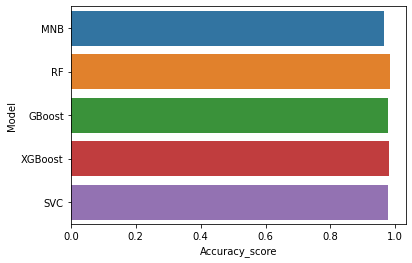

In [35]:
models = pd.DataFrame({
    'Model':['MNB','RF', 'GBoost', 'XGBoost', 'SVC'],
    'Accuracy_score' :[mnb ,rf, gb, xgb, svc]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)